**Programming with Big Data Assignment 3** <br>
**Section: D-3** 
<br>
**Group Members**
<hr>
<i>Usman Shahid (L1F22BSCS1057)</i> <br>
<i>Anas Yousaf (L1F22BSCS1070)</i> <br>
<i>Ahmad Sohail (L1F22BSCS1048)</i> <br>
<hr>
<b>Submitted to: </b> Ms. Misbah Naz

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


# Loading The Dataset

In [2]:
data = pd.read_csv('Retail.csv')
data.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


# Drop Rows with missing values

In [3]:
data.dropna(inplace=True)
print(data.isna().sum())

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


# converting customerID to String

In [4]:
data['CustomerID'] = data['CustomerID'].astype(str)
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


# Compute the total amount spent by each customer

In [5]:
data['Amount'] = data['Quantity'] * data['UnitPrice']
monetary = data.groupby('CustomerID')['Amount'].sum().reset_index()
monetary.columns = ['CustomerID', 'Monetary']
print(monetary)


     CustomerID  Monetary
0       12346.0      0.00
1       12347.0   4310.00
2       12348.0   1797.24
3       12349.0   1757.55
4       12350.0    334.40
...         ...       ...
4367    18280.0    180.60
4368    18281.0     80.82
4369    18282.0    176.60
4370    18283.0   2094.88
4371    18287.0   1837.28

[4372 rows x 2 columns]


# Compute the number of transactions (frequency) by each customer

In [6]:
frequency = data.groupby('CustomerID')['InvoiceNo'].count().reset_index()
frequency.columns = ['CustomerID', 'Frequency']
print(frequency)


     CustomerID  Frequency
0       12346.0          2
1       12347.0        182
2       12348.0         31
3       12349.0         73
4       12350.0         17
...         ...        ...
4367    18280.0         10
4368    18281.0          7
4369    18282.0         13
4370    18283.0        756
4371    18287.0         70

[4372 rows x 2 columns]


# Convert InvoiceDate to datetime

In [7]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format='%d-%m-%Y %H:%M')


# Compute the recency (days since last purchase)

In [8]:
max_date = data['InvoiceDate'].max()
data['Recency'] = (max_date - data.groupby('CustomerID')['InvoiceDate'].transform('max')).dt.days
recency = data[['CustomerID', 'Recency']].drop_duplicates()
print(recency)

       CustomerID  Recency
0         17850.0      301
9         13047.0       31
26        12583.0        2
46        13748.0       95
65        15100.0      329
...           ...      ...
536969    13436.0        1
537255    15520.0        1
538064    13298.0        0
538812    14569.0        0
541768    12713.0        0

[4372 rows x 2 columns]


# Merge the monetary, frequency, and recency dataframes

In [9]:
rfm = monetary.merge(frequency, on='CustomerID').merge(recency, on='CustomerID')
print(rfm)


     CustomerID  Monetary  Frequency  Recency
0       12346.0      0.00          2      325
1       12347.0   4310.00        182        1
2       12348.0   1797.24         31       74
3       12349.0   1757.55         73       18
4       12350.0    334.40         17      309
...         ...       ...        ...      ...
4367    18280.0    180.60         10      277
4368    18281.0     80.82          7      180
4369    18282.0    176.60         13        7
4370    18283.0   2094.88        756        3
4371    18287.0   1837.28         70       42

[4372 rows x 4 columns]


# Standardize the data

In [10]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Monetary', 'Frequency', 'Recency']])
print(rfm_scaled)

[[-0.23100099 -0.3917197   2.32202285]
 [ 0.29343167  0.38265697 -0.89373323]
 [-0.01231622 -0.26695902 -0.1691956 ]
 ...
 [-0.20951263 -0.34439668 -0.83418219]
 [ 0.02390005  2.85205812 -0.87388289]
 [-0.00744423 -0.0991774  -0.48680114]]


# Apply K-means clustering

In [11]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)
print(f'{kmeans}')


KMeans(n_clusters=4, random_state=42)


# Compute the silhouette score

In [12]:
silhouette_avg = silhouette_score(rfm_scaled, rfm['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')


Silhouette Score: 0.5997200972195096


# Analyze the clusters

In [13]:
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).reset_index()

# Rename the columns for clarity

In [14]:
cluster_summary.columns = ['Cluster', 'Mean Recency', 'Mean Frequency', 'Mean Monetary', 'Customer Count']

# Display the cluster summary

In [15]:
print(cluster_summary)

   Cluster  Mean Recency  Mean Frequency  Mean Monetary  Customer Count
0        0     39.027931      105.034377    1994.059792            3258
1        1    245.567543       27.770626     464.787073            1103
2        2      0.666667     4821.500000   55039.933333               6
3        3      8.000000     1013.400000  192103.854000               5


**Visualization of Clusters**

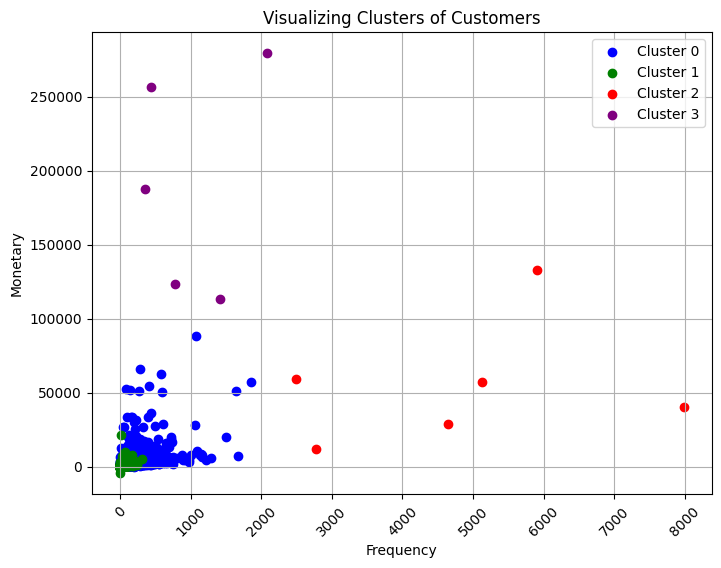

In [16]:
plt.figure(figsize=(8, 6))

colors = ['blue', 'green', 'red', 'purple']

for cluster_label, color in zip(range(4), colors):
    cluster_data = rfm[rfm['Cluster'] == cluster_label]
    plt.scatter(cluster_data['Frequency'], cluster_data['Monetary'], color=color, label=f'Cluster {cluster_label}')

plt.title('Visualizing Clusters of Customers')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()
